In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import cv2
import matplotlib

from models.smpl_official import SMPL

from pytorch3d.transforms import so3

from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from configs.pose2D_hrnet_config import get_pose2D_hrnet_cfg_defaults
from configs.optimization_constants import get_shape_optimization_cfg_defaults
from configs import paths

from ipywidgets import *

from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer

from utils.rigid_transform_utils import rot6d_to_rotmat, aa_rotate_translate_points_pytorch3d

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:
device = torch.device('cuda:0')

pose2D_hrnet_cfg = get_pose2D_hrnet_cfg_defaults()
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()
optimization_cfg = get_shape_optimization_cfg_defaults()

visualise_wh = 512

In [5]:
smpl_model_male = SMPL(paths.SMPL,
                      batch_size=1,
                      gender='male',
                      num_betas=pose_shape_cfg.MODEL.NUM_SMPL_BETAS).to(device)
smpl_model_female = SMPL(paths.SMPL,
                        batch_size=1,
                        gender='female',
                        num_betas=pose_shape_cfg.MODEL.NUM_SMPL_BETAS).to(device)

body_vis_renderer = TexturedIUVRenderer(device=device,
                                        batch_size=1,
                                        img_wh=visualise_wh,
                                        projection_type='orthographic',
                                        render_rgb=True,
                                        bin_size=32)

plain_texture = torch.ones(1, 1200, 800, 3, device=device).float() * 0.7
lights_rgb_settings = {'location': torch.tensor([[0., -0.8, -2.0]], device=device, dtype=torch.float32),
                        'ambient_color': 0.5 * torch.ones(1, 3, device=device, dtype=torch.float32),
                        'diffuse_color': 0.3 * torch.ones(1, 3, device=device, dtype=torch.float32),
                        'specular_color': torch.zeros(1, 3, device=device, dtype=torch.float32)}
fixed_cam_t = torch.tensor([[0., -0.2, 2.5]], device=device)
fixed_orthographic_scale = torch.tensor([[0.95, 0.95]], device=device)


Renderer projection type: orthographic


In [6]:
def render_image(shape, gender):
    if isinstance(shape, list):
        shape = torch.FloatTensor(shape).to(device)
    elif isinstance(shape, np.ndarray):
        shape = torch.from_numpy(shape).to(device).float()
    shape = shape.unsqueeze(0)
    with torch.no_grad():
        if gender == 'M':
            smpl_model = smpl_model_male
        else:
            smpl_model = smpl_model_female
        # Generate SMPL vertices and mesh
        pred_smpl_output_mode = smpl_model(#body_pose=so3.so3_exp_map(pred_pose_rotmats_mode_var)[None, :, :, :],
                                            #global_orient=so3.so3_exp_map(pred_glob_rotmats_var).unsqueeze(1),
                                            betas=shape,
                                            # pose2rot=False
                                        )
        pred_vertices_mode = pred_smpl_output_mode.vertices  # (1, 6890, 3)
        # Need to flip pred_vertices before projecting so that they project the right way up.
        pred_vertices_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_mode,
                                                                axes=torch.tensor([1., 0., 0.], device=device),
                                                                angles=np.pi,
                                                                translations=torch.zeros(3, device=device))
        # Rotating 90° about vertical axis for visualisation
        pred_vertices_rot90_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                        translations=torch.zeros(3, device=device))
        pred_vertices_rot180_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_rot90_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                        translations=torch.zeros(3, device=device))
        pred_vertices_rot270_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_rot180_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                        translations=torch.zeros(3, device=device))

        pred_reposed_smpl_output_mean = smpl_model(betas=shape)
        pred_reposed_vertices_mean = pred_reposed_smpl_output_mean.vertices  # (1, 6890, 3)
        
        # Need to flip pred_vertices before projecting so that they project the right way up.
        pred_reposed_vertices_flipped_mean = aa_rotate_translate_points_pytorch3d(points=pred_reposed_vertices_mean,
                                                                                axes=torch.tensor([1., 0., 0.], device=device),
                                                                                angles=np.pi,
                                                                                translations=torch.zeros(3, device=device))
        # Rotating 90° about vertical axis for visualisation
        pred_reposed_vertices_rot90_mean = aa_rotate_translate_points_pytorch3d(points=pred_reposed_vertices_flipped_mean,
                                                                                axes=torch.tensor([0., 1., 0.], device=device),
                                                                                angles=-np.pi / 2.,
                                                                                translations=torch.zeros(3, device=device))

        # -------------------------------------- VISUALISATION --------------------------------------
        # Render visualisation outputs
        body_vis_output = body_vis_renderer(vertices=pred_vertices_mode,
                                            cam_t=fixed_cam_t,
                                            textures=plain_texture,
                                            orthographic_scale=fixed_orthographic_scale,
                                            lights_rgb_settings=lights_rgb_settings)
        body_vis_rgb = body_vis_output['rgb_images'].permute(0, 3, 1, 2).contiguous().cpu().detach().numpy()[0].transpose(1, 2, 0)

        body_vis_rgb_rot90 = body_vis_renderer(vertices=pred_vertices_rot90_mode,
                                            cam_t=fixed_cam_t,
                                            textures=plain_texture,
                                            orthographic_scale=fixed_orthographic_scale,
                                            lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]
        body_vis_rgb_rot180 = body_vis_renderer(vertices=pred_vertices_rot180_mode,
                                                cam_t=fixed_cam_t,
                                                textures=plain_texture,
                                                orthographic_scale=fixed_orthographic_scale,
                                                lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]
        body_vis_rgb_rot270 = body_vis_renderer(vertices=pred_vertices_rot270_mode,
                                                textures=plain_texture,
                                                cam_t=fixed_cam_t,
                                                orthographic_scale=fixed_orthographic_scale,
                                                lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]

        # Reposed body visualisation
        reposed_body_vis_rgb = body_vis_renderer(vertices=pred_reposed_vertices_flipped_mean,
                                                textures=plain_texture,
                                                cam_t=fixed_cam_t,
                                                orthographic_scale=fixed_orthographic_scale,
                                                lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]
        reposed_body_vis_rgb_rot90 = body_vis_renderer(vertices=pred_reposed_vertices_rot90_mean,
                                                    textures=plain_texture,
                                                    cam_t=fixed_cam_t,
                                                    orthographic_scale=fixed_orthographic_scale,
                                                    lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]

        # # Combine all visualisations
        # combined_vis_rows = 2
        # combined_vis_cols = 3
        # combined_vis_fig = np.zeros((combined_vis_rows * visualise_wh, combined_vis_cols * visualise_wh, 3),
        #                             dtype=body_vis_rgb.dtype)

        # # Posed 3D body
        # combined_vis_fig[:visualise_wh, :visualise_wh] = body_vis_rgb
        # combined_vis_fig[visualise_wh:2*visualise_wh, :visualise_wh] = body_vis_rgb_rot90
        # combined_vis_fig[:visualise_wh, visualise_wh:2*visualise_wh] = body_vis_rgb_rot180
        # combined_vis_fig[visualise_wh:2*visualise_wh, visualise_wh:2*visualise_wh] = body_vis_rgb_rot270

        # # T-pose 3D body
        # combined_vis_fig[:visualise_wh, 2*visualise_wh:3*visualise_wh] = reposed_body_vis_rgb
        # combined_vis_fig[visualise_wh:2*visualise_wh, 2*visualise_wh:3*visualise_wh] = reposed_body_vis_rgb_rot90

        return body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90

In [7]:
def render_image_diff(shape, shape2, gender, cmap=plt.cm.jet):
    if isinstance(shape, list):
        shape = torch.FloatTensor(shape).to(device)
    elif isinstance(shape, np.ndarray):
        shape = torch.from_numpy(shape).to(device).float()
    if isinstance(shape2, list):
        shape2 = torch.FloatTensor(shape2).to(device)
    elif isinstance(shape2, np.ndarray):
        shape2 = torch.from_numpy(shape2).to(device).float()
    shape = shape.unsqueeze(0)
    shape2 = shape2.unsqueeze(0)
    with torch.no_grad():
        if gender == 'M':
            smpl_model = smpl_model_male
        else:
            smpl_model = smpl_model_female
        # Generate SMPL vertices and mesh
        pred_smpl_output_mode = smpl_model(#body_pose=so3.so3_exp_map(pred_pose_rotmats_mode_var)[None, :, :, :],
                                            #global_orient=so3.so3_exp_map(pred_glob_rotmats_var).unsqueeze(1),
                                            betas=shape,
                                            # pose2rot=False
                                        )
        pred_vertices_mode = pred_smpl_output_mode.vertices#.unsqueeze(0)  # (1, 6890, 3)


        alternative_vertices_mode = smpl_model(betas=shape2)
        alternative_vertices_mode = alternative_vertices_mode.vertices#.vertices.unsqueeze(0)
        # Need to flip pred_vertices before projecting so that they project the right way up.
        pred_vertices_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_mode,
                                                                axes=torch.tensor([1., 0., 0.], device=device),
                                                                angles=np.pi,
                                                                translations=torch.zeros(3, device=device))

        alternative_vertices_mode = aa_rotate_translate_points_pytorch3d(points=alternative_vertices_mode,
                                                                axes=torch.tensor([1., 0., 0.], device=device),
                                                                angles=np.pi,
                                                                translations=torch.zeros(3, device=device))
        
        diffs = torch.norm(pred_vertices_mode - alternative_vertices_mode, dim=-1).squeeze()
        print('Max diff: {}'.format(torch.max(diffs).item()))
        vertex_color_norm = plt.Normalize(vmin=0.0, vmax=max(0.001, torch.max(diffs).item()), clip=True)
        vertex_colors = cmap(vertex_color_norm(diffs.cpu().detach().numpy()))[:, :3]
        vertex_colors = torch.from_numpy(vertex_colors[None, :, :]).to(device).float()

        # Rotating 90° about vertical axis for visualisation
        pred_vertices_rot90_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                        translations=torch.zeros(3, device=device))
        pred_vertices_rot180_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_rot90_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                         translations=torch.zeros(3, device=device))
        pred_vertices_rot270_mode = aa_rotate_translate_points_pytorch3d(points=pred_vertices_rot180_mode,
                                                                        axes=torch.tensor([0., 1., 0.], device=device),
                                                                        angles=-np.pi / 2.,
                                                                        translations=torch.zeros(3, device=device))

        pred_reposed_smpl_output_mean = smpl_model(betas=shape)
        pred_reposed_vertices_mean = pred_reposed_smpl_output_mean.vertices  # (1, 6890, 3)
        
        # Need to flip pred_vertices before projecting so that they project the right way up.
        pred_reposed_vertices_flipped_mean = aa_rotate_translate_points_pytorch3d(points=pred_reposed_vertices_mean,
                                                                                axes=torch.tensor([1., 0., 0.], device=device),
                                                                                angles=np.pi,
                                                                                translations=torch.zeros(3, device=device))
        # Rotating 90° about vertical axis for visualisation
        pred_reposed_vertices_rot90_mean = aa_rotate_translate_points_pytorch3d(points=pred_reposed_vertices_flipped_mean,
                                                                                axes=torch.tensor([0., 1., 0.], device=device),
                                                                                angles=-np.pi / 2.,
                                                                                translations=torch.zeros(3, device=device))

        # -------------------------------------- VISUALISATION --------------------------------------
        # Render visualisation outputs
        body_vis_output = body_vis_renderer(vertices=pred_vertices_mode,
                                            cam_t=fixed_cam_t,
                                            textures=plain_texture,
                                            orthographic_scale=fixed_orthographic_scale,
                                            lights_rgb_settings=lights_rgb_settings,
                                            verts_features=vertex_colors)
        body_vis_rgb = body_vis_output['rgb_images'].permute(0, 3, 1, 2).contiguous().cpu().detach().numpy()[0].transpose(1, 2, 0)

        body_vis_rgb_rot90 = body_vis_renderer(vertices=pred_vertices_rot90_mode,
                                            cam_t=fixed_cam_t,
                                            textures=plain_texture,
                                            orthographic_scale=fixed_orthographic_scale,
                                            lights_rgb_settings=lights_rgb_settings,
                                            verts_features=vertex_colors)['rgb_images'].cpu().detach().numpy()[0]
        body_vis_rgb_rot180 = body_vis_renderer(vertices=pred_vertices_rot180_mode,
                                                cam_t=fixed_cam_t,
                                                textures=plain_texture,
                                                orthographic_scale=fixed_orthographic_scale,
                                                lights_rgb_settings=lights_rgb_settings,
                                                verts_features=vertex_colors)['rgb_images'].cpu().detach().numpy()[0]
        body_vis_rgb_rot270 = body_vis_renderer(vertices=pred_vertices_rot270_mode,
                                                textures=plain_texture,
                                                cam_t=fixed_cam_t,
                                                orthographic_scale=fixed_orthographic_scale,
                                                lights_rgb_settings=lights_rgb_settings,
                                                verts_features=vertex_colors)['rgb_images'].cpu().detach().numpy()[0]

        # Reposed body visualisation
        # reposed_body_vis_rgb = body_vis_renderer(vertices=pred_reposed_vertices_flipped_mean,
        #                                         textures=plain_texture,
        #                                         cam_t=fixed_cam_t,
        #                                         orthographic_scale=fixed_orthographic_scale,
        #                                         lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]
        # reposed_body_vis_rgb_rot90 = body_vis_renderer(vertices=pred_reposed_vertices_rot90_mean,
        #                                             textures=plain_texture,
        #                                             cam_t=fixed_cam_t,
        #                                             orthographic_scale=fixed_orthographic_scale,
        #                                             lights_rgb_settings=lights_rgb_settings)['rgb_images'].cpu().detach().numpy()[0]

        return body_vis_rgb, body_vis_rgb_rot90, matplotlib.cm.ScalarMappable(vertex_color_norm, cmap)

In [10]:
def show_image(shape, gender, figsize=(10, 6), transpose=False):
    body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90 = render_image(shape, gender)
    if transpose:
        fig, axs = plt.subplots(2, 1)
    else:
        fig, axs = plt.subplots(1, 2)
    axs[0].imshow(body_vis_rgb)
    axs[1].imshow(body_vis_rgb_rot90)
    # axs[1, 0].imshow(reposed_body_vis_rgb)
    # axs[1, 1].imshow(reposed_body_vis_rgb_rot90)
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    fig.set_size_inches(figsize[0], figsize[1])
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

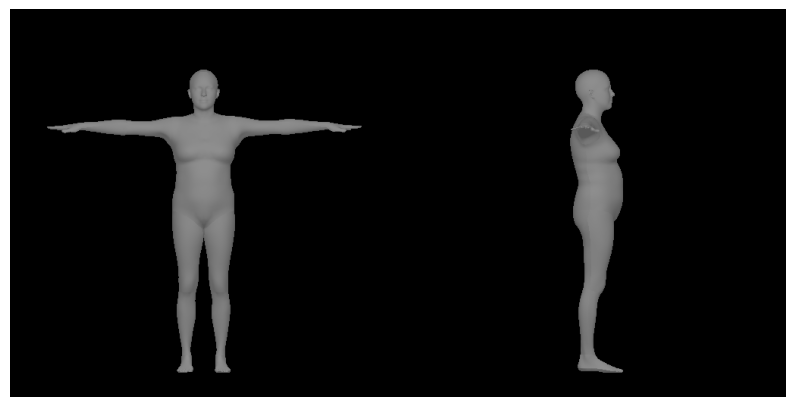

In [11]:
show_image(
    shape=[0.184959, -0.337896, -1.609612, 0.002630, 0.433594, -2.425279, 1.617330, -1.639235, 0.141148, 0.547119],
    gender='F'
)

In [ ]:
show_image(
    shape=[0.180954, -0.268555, -1.319801, 1.097688, -1.399684, -0.971046, 0.012342, -0.880540, 0.567660, 2.033137],
    gender='F'
)

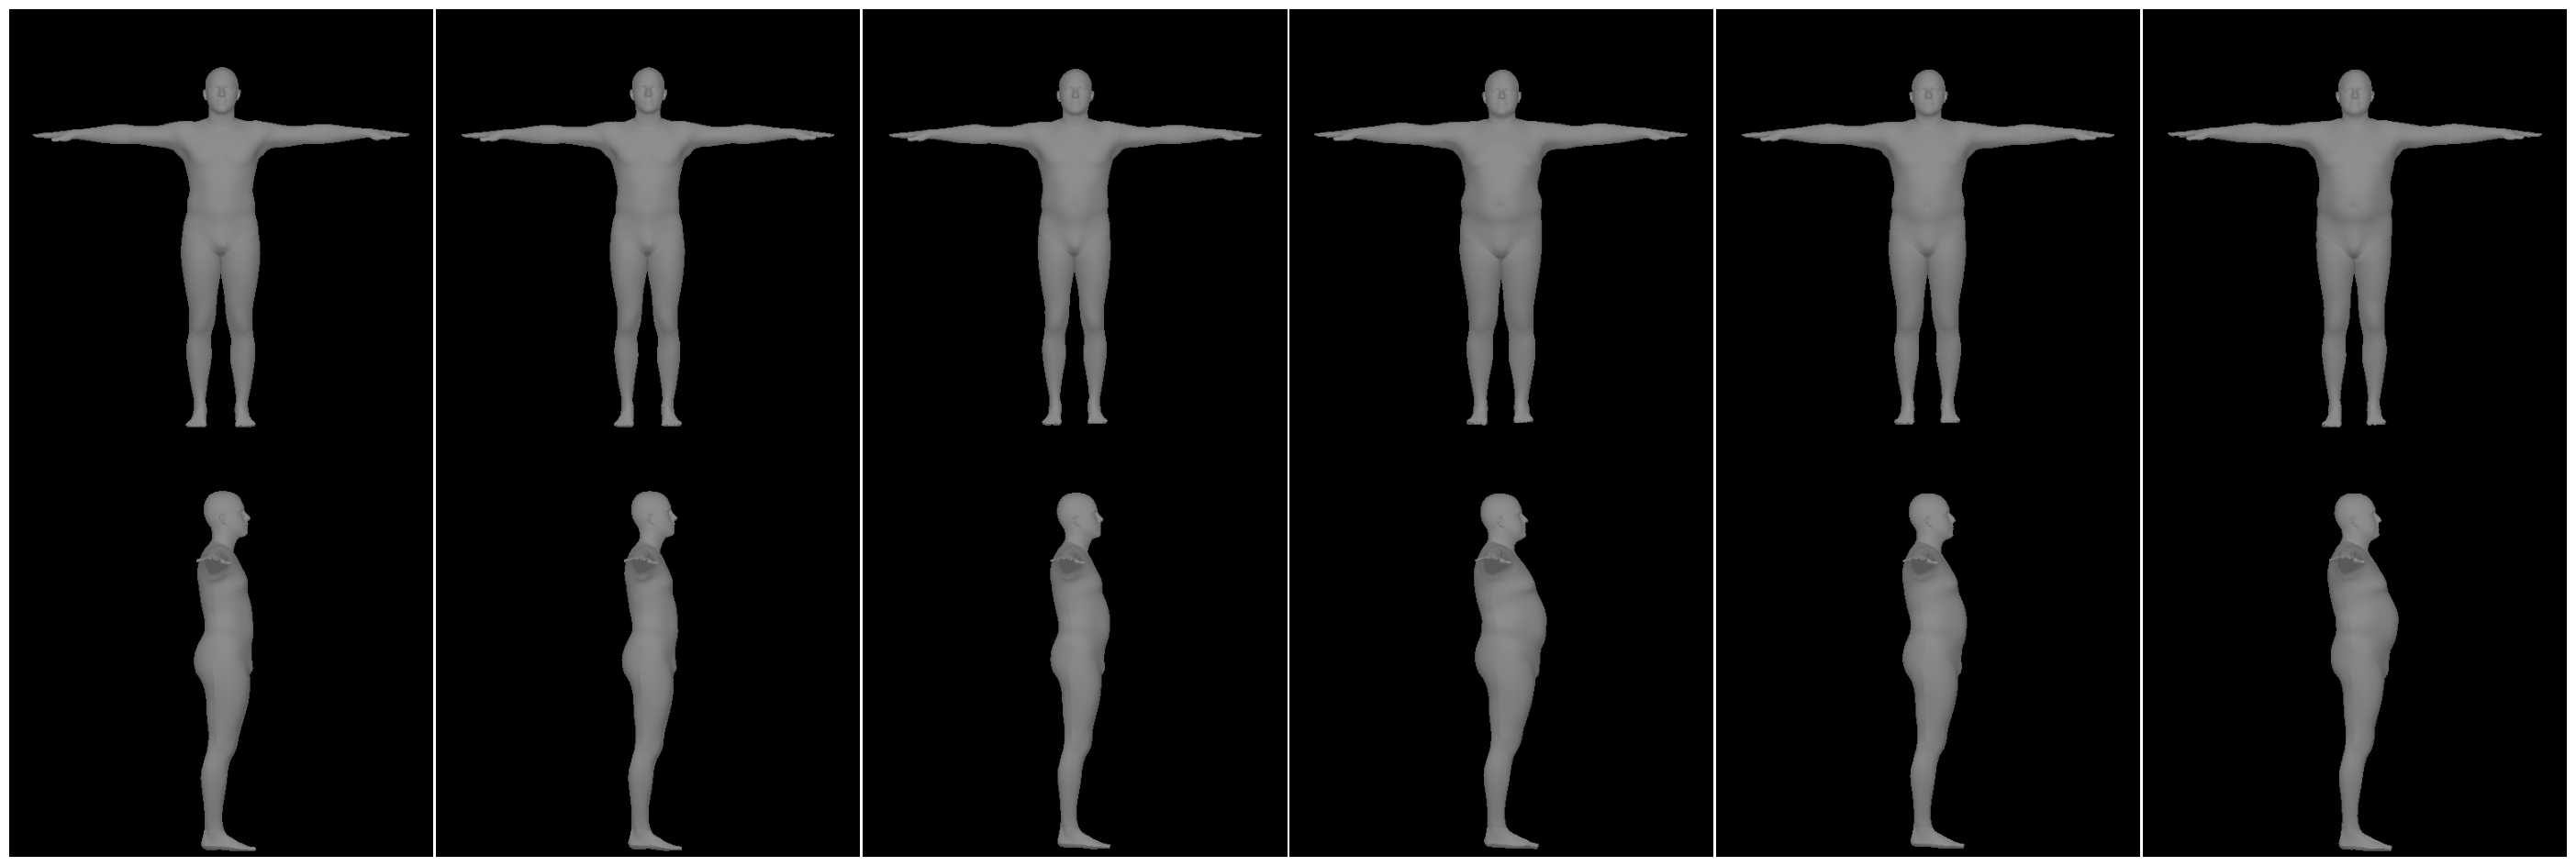

In [10]:
cluster_means = [[-0.37304, 1.02748, -0.84481, -0.12543, 1.41597, 1.00472, -1.37114, -0.75562, 0.76084, 0.23238],
[0.03959, 0.24479, -1.15393, -0.65263, 1.53978, 0.24951, -0.59560, -1.06096, 0.10719, 1.09628],
[-0.07545, -1.31169, -1.09363, -2.52737, 2.44191, 1.82333, -0.49603, 0.23523, 1.02716, -0.37718],
[-0.05759, -0.75036, -1.23627, -2.11616, 2.06674, 0.66219, 0.18999, -0.45213, 0.25257, 0.75301],
[0.06901, -0.36358, -1.46369, -1.06760, 1.85019, 1.35625, -1.35855, -0.57843, 0.51838, 0.29824],
[-0.10998, -0.35318, -1.21278, -1.70951, 1.85106, -0.56257, 0.69637, -1.03551, -0.26253, 1.79217]]
gender = 'M'

fig, axs = plt.subplots(2, len(cluster_means))
for i in range(len(cluster_means)):
    body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90 = render_image(cluster_means[i], gender)
    axs[0, i].imshow(body_vis_rgb)
    axs[1, i].imshow(body_vis_rgb_rot90)

for row in axs:
    for col in row:
        col.set_axis_off()

fig.set_size_inches(6 * axs.shape[1], 6 * axs.shape[0])
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

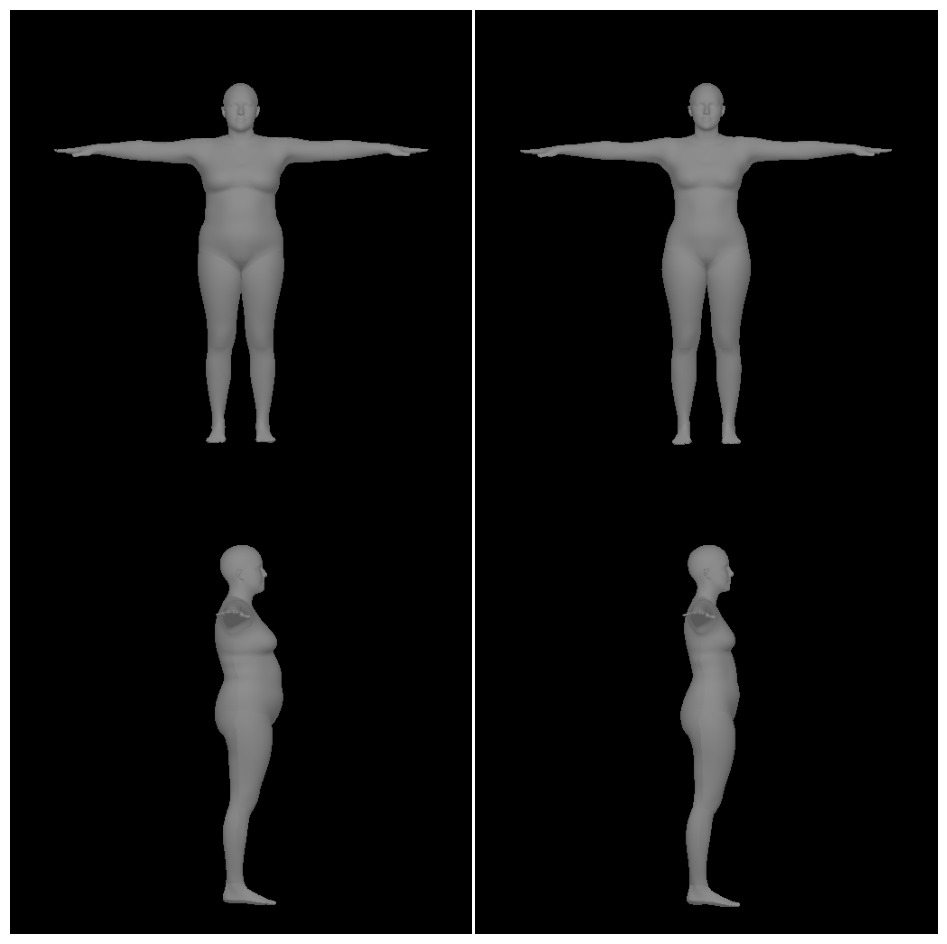

In [11]:
cluster_means = [[0.21652, -0.98239, -1.27365, 1.10543, -1.08032, -1.26414, 0.56644, -1.28418, 0.54220, 1.07221],
[0.18333, 0.24747, -1.28574, 0.92597, -1.79129, -0.60654, -0.64848, -0.54972, 0.44460, 3.21219]]
gender = 'F'

fig, axs = plt.subplots(2, len(cluster_means))
for i in range(len(cluster_means)):
    body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90 = render_image(cluster_means[i], gender)
    axs[0, i].imshow(body_vis_rgb)
    axs[1, i].imshow(body_vis_rgb_rot90)

for row in axs:
    for col in row:
        col.set_axis_off()

fig.set_size_inches(6 * axs.shape[1], 6 * axs.shape[0])
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Max diff: 0.28777962923049927
Max diff: 0.13815242052078247
Max diff: 0.05460046976804733
Max diff: 0.03628578782081604
Max diff: 0.0226246677339077
Max diff: 0.024685565382242203
Max diff: 0.036576706916093826
Max diff: 0.021931268274784088
Max diff: 0.016948936507105827
Max diff: 0.0182331670075655


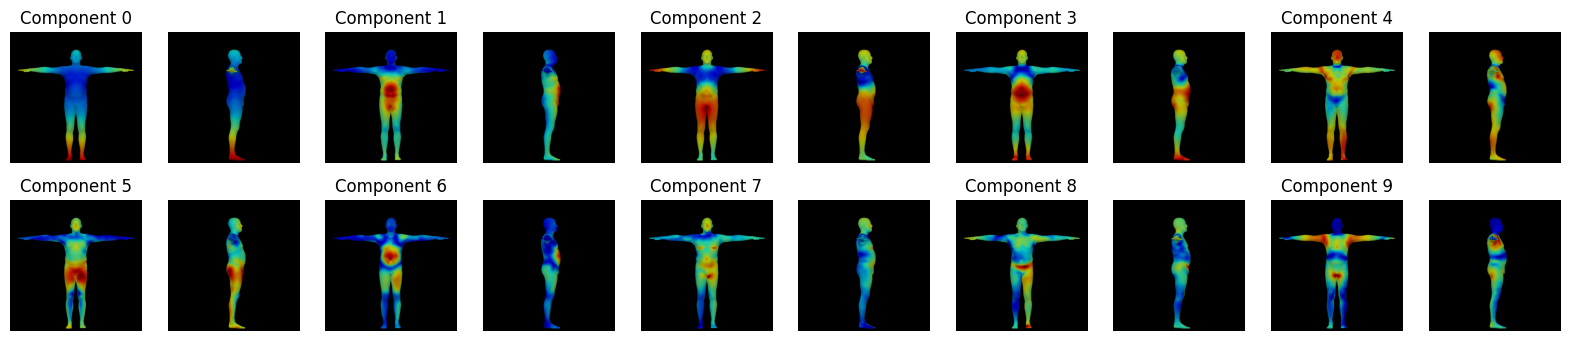

In [12]:
original_shape = np.array([-0.00720, -0.30281, -1.23116, -1.48172, 1.79973, 0.01030, 0.16253, -0.91652, -0.06267, 1.32393])
gender = 'M'
diffs = np.identity(len(original_shape)) * 5

row_length = 10
figsize = 2
fig, axs = plt.subplots(int(np.ceil(20 / row_length)), row_length)
for i in range(10):
    current_ax1 = axs[(i * 2) // row_length, (i * 2) % row_length]
    current_ax2 = axs[(i * 2) // row_length, (i * 2) % row_length + 1]
    body_vis_rgb, body_vis_rgb_rot90, _ = render_image_diff(
        shape=original_shape,
        shape2=original_shape + diffs[i],
        gender=gender
    )
    current_ax1.imshow(body_vis_rgb)
    current_ax2.imshow(body_vis_rgb_rot90)
    current_ax1.title.set_text('Component {}'.format(i))
for row in axs:
    for col in row:
        col.set_axis_off()
if axs.shape[0] * axs.shape[1] > 20:
    for i in range(10, (axs.shape[0] * axs.shape[1]) // 2):
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length])
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length + 1])
fig.set_size_inches(axs.shape[1] * figsize, axs.shape[0] * figsize)
plt.show()

Max diff: 0.2641328275203705
Max diff: 0.1540597528219223
Max diff: 0.05241614952683449
Max diff: 0.03614642098546028
Max diff: 0.028327396139502525
Max diff: 0.02604135125875473
Max diff: 0.034417588263750076
Max diff: 0.01984756998717785
Max diff: 0.014824580401182175
Max diff: 0.01490667276084423


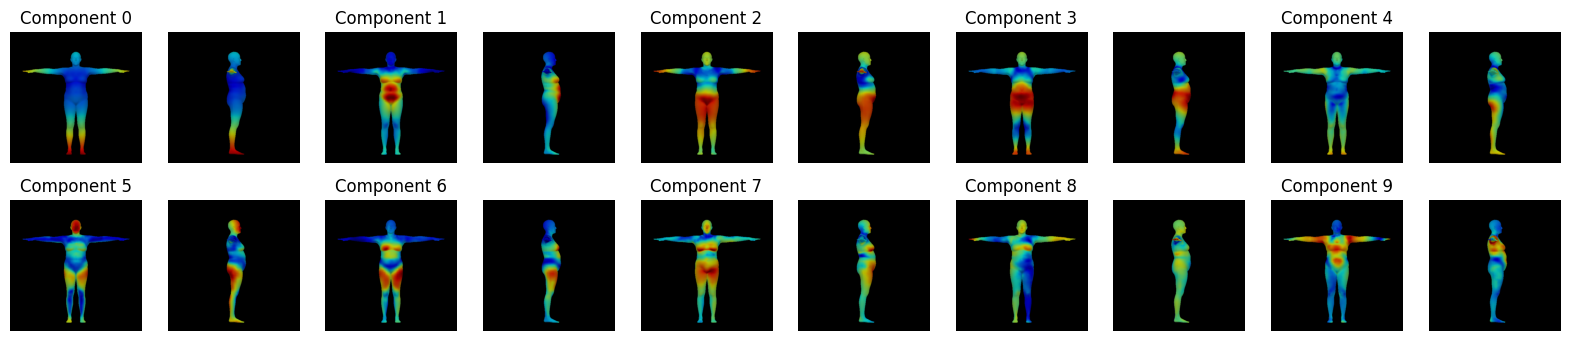

In [13]:
original_shape = np.array([0.24670, -0.95404, -1.36538, 0.87083, -0.81396, -1.60768, 1.01235, -1.42749, 0.47059, 0.88919])
gender = 'F'
diffs = np.identity(len(original_shape)) * 5

row_length = 10
figsize = 2
fig, axs = plt.subplots(int(np.ceil(20 / row_length)), row_length)
for i in range(10):
    current_ax1 = axs[(i * 2) // row_length, (i * 2) % row_length]
    current_ax2 = axs[(i * 2) // row_length, (i * 2) % row_length + 1]
    body_vis_rgb, body_vis_rgb_rot90, _ = render_image_diff(
        shape=original_shape,
        shape2=original_shape + diffs[i],
        gender=gender
    )
    current_ax1.imshow(body_vis_rgb)
    current_ax2.imshow(body_vis_rgb_rot90)
    current_ax1.title.set_text('Component {}'.format(i))
for row in axs:
    for col in row:
        col.set_axis_off()
if axs.shape[0] * axs.shape[1] > 20:
    for i in range(10, (axs.shape[0] * axs.shape[1]) // 2):
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length])
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length + 1])
fig.set_size_inches(axs.shape[1] * figsize, axs.shape[0] * figsize)
plt.show()

Max diff: 0.1540597379207611
Max diff: 0.036146409809589386
Max diff: 0.034417569637298584
Max diff: 0.019847556948661804
Max diff: 0.014824637211859226
Max diff: 0.01490667276084423


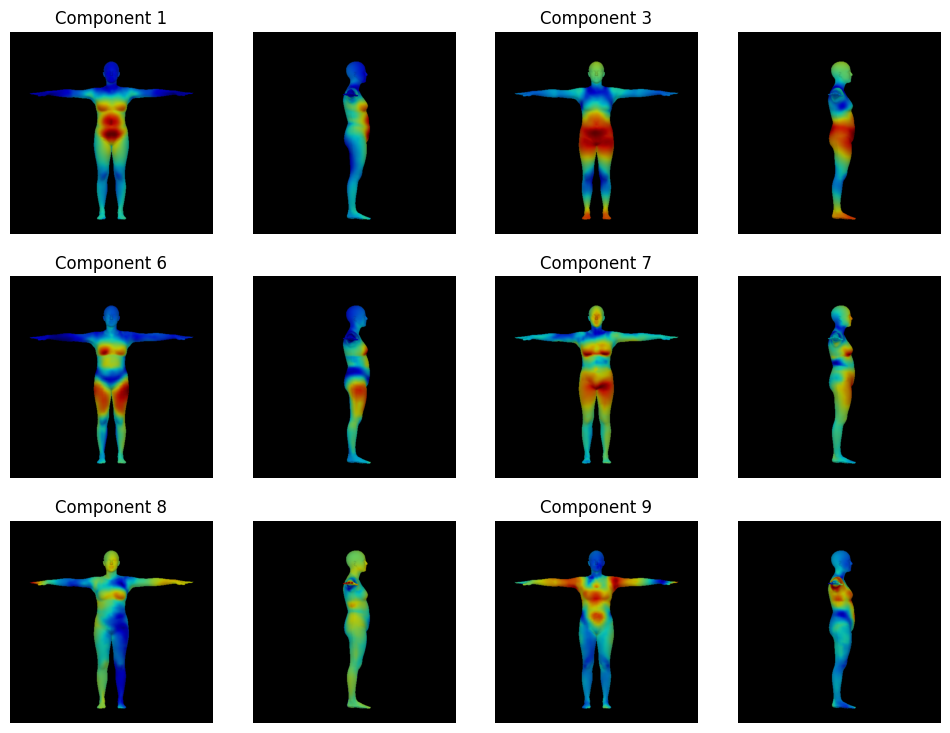

In [10]:
original_shape = np.array([-0.00720, -0.30281, -1.23116, -1.48172, 1.79973, 0.01030, 0.16253, -0.91652, -0.06267, 1.32393])
gender = 'F'
diffs = np.identity(len(original_shape)) * 5

row_length = 4
figsize = 3
component_nums = [1, 3,6,7,8,9]
fig, axs = plt.subplots(int(np.ceil(len(component_nums) * 2 / row_length)), row_length)
for i in range(len(component_nums)):
    current_ax1 = axs[(i * 2) // row_length, (i * 2) % row_length]
    current_ax2 = axs[(i * 2) // row_length, (i * 2) % row_length + 1]
    body_vis_rgb, body_vis_rgb_rot90, _ = render_image_diff(
        shape=original_shape,
        shape2=original_shape + diffs[component_nums[i]],
        gender=gender
    )
    current_ax1.imshow(body_vis_rgb)
    current_ax2.imshow(body_vis_rgb_rot90)
    current_ax1.title.set_text('Component {}'.format(component_nums[i]))
for row in axs:
    for col in row:
        col.set_axis_off()
if axs.shape[0] * axs.shape[1] > len(component_nums) * 2:
    for i in range(len(component_nums), (axs.shape[0] * axs.shape[1]) // 2):
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length])
        fig.delaxes(axs[(i * 2) // row_length, (i * 2) % row_length + 1])
fig.set_size_inches(axs.shape[1] * figsize, axs.shape[0] * figsize)
plt.show()

## Interactive Plots

In [27]:
%matplotlib widget
plt.close('all')
original_shape = np.array([-0.00720, -0.30281, -1.23116, -1.48172, 1.79973, 0.01030, 0.16253, -0.91652, -0.06267, 1.32393])
gender = 'M'
body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90 = render_image(
    shape=original_shape,
    gender=gender
)

with plt.ioff():
    fig, axs = plt.subplots(2,2)
    img1 = axs[0, 0].imshow(body_vis_rgb)
    img2 = axs[0, 1].imshow(body_vis_rgb_rot90)
    axs[1, 0].imshow(body_vis_rgb)
    axs[1, 1].imshow(body_vis_rgb_rot90)
    fig.set_size_inches(10, 10)

def update(d0=0, d1=0, d2=0, d3=0, d4=0, d5=0, d6=0, d7=0, d8=0, d9=0):
    deltas = np.array([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    print(deltas)
    shape = original_shape + deltas
    body_vis_rgb, body_vis_rgb_rot90, reposed_body_vis_rgb, reposed_body_vis_rgb_rot90 = render_image(
        shape=shape,
        gender=gender
    )
    img1.set_data(body_vis_rgb)
    img2.set_data(body_vis_rgb_rot90)
    display(fig)

widget1 = interact(update, **{'d{}'.format(i): (-5., 5., 0.05) for i in range(10)})

interactive(children=(FloatSlider(value=0.0, description='d0', max=5.0, min=-5.0, step=0.05), FloatSlider(valu…

In [28]:
del widget1
%matplotlib inline

In [32]:
%matplotlib widget
plt.close('all')
original_shape = np.array([0.24670, -0.95404, -1.36538, 0.87083, -0.81396, -1.60768, 1.01235, -1.42749, 0.47059, 0.88919])
gender = 'F'
body_vis_rgb, body_vis_rgb_rot90, scalar_mappable = render_image_diff(
        shape=original_shape,
        shape2=original_shape,
        gender=gender
    )

with plt.ioff():
    fig, axs = plt.subplots(1,2)
    img1 = axs[0].imshow(body_vis_rgb)
    img2 = axs[1].imshow(body_vis_rgb_rot90)
    cbar = fig.colorbar(scalar_mappable, ax=axs, orientation='horizontal')
    fig.set_size_inches(10, 10)

def update_diff(d0=0, d1=0, d2=0, d3=0, d4=0, d5=0, d6=0, d7=0, d8=0, d9=0):
    deltas = np.array([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    print(deltas)
    shape = original_shape + deltas
    body_vis_rgb, body_vis_rgb_rot90, scalar_mappable = render_image_diff(
        shape=original_shape,
        shape2=shape,
        gender=gender
    )
    img1.set_data(body_vis_rgb)
    img2.set_data(body_vis_rgb_rot90)
    cbar.update_normal(scalar_mappable)
    display(fig)

widget2 = interact(update_diff, **{'d{}'.format(i): (-5., 5., 0.05) for i in range(10)})

Max diff: 0.0


interactive(children=(FloatSlider(value=0.0, description='d0', max=5.0, min=-5.0, step=0.05), FloatSlider(valu…

In [30]:
del widget2
%matplotlib inline